In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
sys.path.append('../data/')

# M5 Forecasting
This competition (https://www.kaggle.com/c/m5-forecasting-accuracy/overview) aims to forecast Walmart sale forecast daily sales for the next 28 days. The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events.

This notebook uses M5 data to demonstrate the time series models `wavenet`

## Create data loader

Train and Validation Series Partioning. We need to create 4 sub-segments of the data as the figure below:

1. Train encoding period
2. Train decoding period (train targets, 28 days)
3. Validation encoding period
4. Validation decoding period (validation targets, 28 days)

<img src="fig/web-traffic-train-validation-split.png" width="700" align="left">

### Features
We have 4 kinds of features
- time series: 
    - shape: [nr_ts, len_encode, 1] and [nr_ts, len_decode, 1]
    - current only support 1 dimension. For multivariance time series forecasting, the code in seq2seq.py need to change.
- numerical features: 
    - shape: [nr_ts, len_encode, num_dim] and [nr_ts, len_decode, num_dim]
    - numerical exogenous variable, for example, the daily temprature. In M5 data, we use historical sales (1 year and 3 months ago)
- categorical features
    - shape: [nr_ts, len_encode, cat_dim] and [nr_ts, len_decode, cat_dim]
    - categorical exogenous variable. In M5 data, they are week number, event name, etc
- fixed feature
    - shape: [nr_ts, fixed_feat_dim]
    - fixed features value does not change for the given time series, for example, the store id and state id

In [3]:
from m5_dataloader import *
import torch
from torch.utils.data import DataLoader

input_dir = '../data/M5'

train_encode_decode_boundray = ('2015-03-01', '2016-02-28', '2016-02-29', '2016-03-27')
val_encode_decode_boundray = ('2015-03-29', '2016-03-27', '2016-03-28', '2016-04-24')

categorical_feat_l = ['week_number',
                    'wday',
                    'month',
                    'event_name_1',
                    'event_type_1',
                    'event_name_2',
                    'event_type_2',
                    'snap_CA',
                    'snap_TX',
                    'snap_WI']


fixed_feat_l=['item_id',
            'dept_id',
            'cat_id',
            'store_id',
            'state_id']

xdaysago = [365, 91]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

calendar, sell_prices, sales_train, submission = read_data(input_dir)
sales_train = process_sale_data(sales_train)
processed_calendar = process_calendar(calendar)

train_tuple = get_encode_decode_data(*train_encode_decode_boundray,
                                     sales_train,
                                     calendar,
                                     processed_calendar,
                                     categorical_feat_l,
                                     xdaysago=xdaysago,
                                     is_pred=False)

val_tuple = get_encode_decode_data(*val_encode_decode_boundray,
                                   sales_train,
                                   calendar,
                                   processed_calendar,
                                   categorical_feat_l,
                                   xdaysago=xdaysago,
                                   is_pred=False)

fixed_feat = get_fixed_feat(fixed_feat_l, sales_train)

dataset_train = TSDataset(device, *train_tuple, fixed_feat)

dataset_val = TSDataset(device, *val_tuple, fixed_feat)


INFO:root:Reading files...


Calendar shape: (1969, 14)
Sell prices shape: (6841121, 4)
Sales train shape: (30490, 1919)
Submission shape: (60980, 29)
ts_encode_norm shape torch.Size([30490, 365, 1])
 ts_decode_norm shape torch.Size([30490, 28, 1])
 ts_decode_true shape torch.Size([30490, 28, 1])
 ts_xdaysago_encode shape torch.Size([30490, 365, 2])
 ts_xdaysago_decode shape torch.Size([30490, 28, 2])
 cat_feat_encode shape torch.Size([30490, 365, 10])
 cat_feat_decode shape torch.Size([30490, 28, 10])
 fixed_feat_encode shape torch.Size([30490, 5])
 mean_x shape torch.Size([30490, 1, 1])
 std_x shape torch.Size([30490, 1, 1])

ts_encode_norm shape torch.Size([30490, 365, 1])
 ts_decode_norm shape torch.Size([30490, 28, 1])
 ts_decode_true shape torch.Size([30490, 28, 1])
 ts_xdaysago_encode shape torch.Size([30490, 365, 2])
 ts_xdaysago_decode shape torch.Size([30490, 28, 2])
 cat_feat_encode shape torch.Size([30490, 365, 10])
 cat_feat_decode shape torch.Size([30490, 28, 10])
 fixed_feat_encode shape torch.Size(

In [4]:
from seq2seq import *

BATCH_SIZE = 64
dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=0,
                              drop_last=True)

dataloader_val = DataLoader(dataset_val,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=0,
                            drop_last=False)

## WaveNet model

Here is a very good serial of tutorials about WaveNet model. I will not describle how WaveNet works here. 
- https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Intro.ipynb
- https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Full.ipynb
https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Full_Exog.ipynb

In our code, similar as the Seq2Seq model, we have a feature embedding layer to concatenate time series and embedded exogenous features. The diagram is shown as the figure below

<img src="fig/wavenet_diagram.png" width="600" align="center">

In [5]:
from embedding import CategoricalEmbedding, FixedFeatEmbedding
from wavenet import WaveNet, WaveNetTS

NR_RESIDUAL_CHANNEL = 32
NR_SKIP_CHANNEL = 32
OUTPUT_DIM = 1
NR_LAYERS = 8
STACK_TIME = 1
DECODE_LEN = 28

categorical_feat_emb_lookup = get_cat_feat_emb_para(categorical_feat_l, processed_calendar)
fixed_feat_emb_lookup = get_fixed_feat_emb_para(fixed_feat_l, sales_train)

cat_emb_layer = CategoricalEmbedding(categorical_feat_emb_lookup)
fixed_emb_layer = FixedFeatEmbedding(fixed_feat_emb_lookup)

INPUT_DIM_ENCODE = 1 + \
            sum([cat[2] for cat in categorical_feat_emb_lookup]) +\
            sum([fixed_feat[2] for fixed_feat in fixed_feat_emb_lookup]) +\
            len(xdaysago)

INPUT_DIM_DECODE = INPUT_DIM_ENCODE

wavenet = WaveNet(n_in_channels=INPUT_DIM_DECODE, 
                 n_residual_channels=NR_RESIDUAL_CHANNEL, 
                 n_skip_channels=NR_SKIP_CHANNEL, 
                 n_out_channels=OUTPUT_DIM, 
                 nr_layers=NR_LAYERS,
                 stack_time=STACK_TIME,
                 decode_len=DECODE_LEN,
                 device=device)  

model = WaveNetTS(wavenet, cat_emb_layer, fixed_emb_layer, device)

In [11]:
from torch import optim
from scheduler import OneCycleLR
from train import train, evaluate
from utils import RMSELoss, epoch_time, EarlyStopping
import time

LR = 0.001
N_EPOCHS = 30
CLIP = 2
FORCH_TEACHING_RATE = 0 # not use force teaching in the time series forecasting?
EARLY_STOP_PATIENT = 4

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = OneCycleLR(optimizer, n_epochs=N_EPOCHS, n_batches=len(dataloader_train))
criterion = RMSELoss()

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=EARLY_STOP_PATIENT, verbose=True)

best_valid_loss = float('inf')
best_epoch_l = []
train_loss_l = []
valid_loss_l = []
valid_loss_orig_l = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, dataloader_train, optimizer, scheduler, criterion, CLIP, FORCH_TEACHING_RATE)
    valid_loss, valid_loss_orig = evaluate(model, dataloader_val, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_epoch_l.append(epoch)
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f'seq2seq.pt')

        
    train_loss_l.append(train_loss)
    valid_loss_l.append(valid_loss)
    valid_loss_orig_l.append(valid_loss_orig)

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model, epoch, optimizer.param_groups[0]['lr'])

    if epoch % 1 == 0:
        print(f'Epoch: {epoch:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.6f}')
        print(f'\t Val. Loss: {valid_loss:.6f}')
        print(f'\t Val. orig Loss: {valid_loss_orig:.6f}')
        lr = optimizer.param_groups[0]['lr']
        print(f'\tLR: {lr}')        

    if early_stopping.early_stop:
        print("Early stopping")
        break  


Validation loss decreased (inf --> 1.242529).  Saving model ...
Epoch: 00 | Time: 0m 38s
	Train Loss: 1.110921
	 Val. Loss: 1.242529
	 Val. orig Loss: 1.970396
	LR: 6.894754202276398e-05
EarlyStopping counter: 1 out of 4 in epoch 1 lr 0.000152; 
		Loss 1.244763; Best score -1.242529
Epoch: 01 | Time: 0m 37s
	Train Loss: 1.109101
	 Val. Loss: 1.244763
	 Val. orig Loss: 1.978165
	LR: 0.00015229866730289066
EarlyStopping counter: 2 out of 4 in epoch 2 lr 0.000280; 
		Loss 1.252035; Best score -1.242529
Epoch: 02 | Time: 0m 37s
	Train Loss: 1.109577
	 Val. Loss: 1.252035
	 Val. orig Loss: 2.001004
	LR: 0.00028000000000000003
EarlyStopping counter: 3 out of 4 in epoch 3 lr 0.000437; 
		Loss 1.248894; Best score -1.242529
Epoch: 03 | Time: 0m 37s
	Train Loss: 1.108273
	 Val. Loss: 1.248894
	 Val. orig Loss: 1.990990
	LR: 0.00043664887471987334
EarlyStopping counter: 4 out of 4 in epoch 4 lr 0.000603; 
		Loss 1.247224; Best score -1.242529
Epoch: 04 | Time: 0m 37s
	Train Loss: 1.106864
	 Val.

### Visualization of the prediction

pred shape (30490, 28)
Visualize time series [7736]
0.5935377216828036


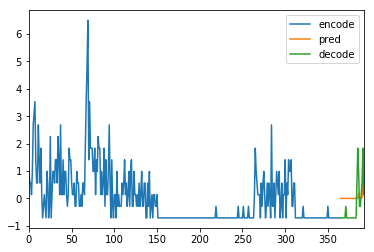

In [12]:
from m5_dataloader import M5_LEN_DECODE, M5_LEN_ENCODE
from utils import vis

pred_norm, decode_norm = vis(dataloader_val, model, len_encode=M5_LEN_ENCODE, len_decode=M5_LEN_DECODE, device=device)
loss = np.mean((pred_norm-decode_norm)**2)
print(loss)